# 07. Compare All Models (3 CNNs + Random Forest)

This notebook compares deforestation detection results from all 4 models:

**CNN Models:**
1. Spatial Context CNN
2. Multi-Scale CNN
3. Shallow U-Net

**Traditional ML:**
4. Random Forest

**Workflow:**
1. Run inference for all 3 CNN models separately
2. Load results from Random Forest (from notebook 06)
3. Compare probability maps side-by-side
4. Compare binary classification maps
5. Analyze statistics and model agreement

**Expected outputs:**
- Side-by-side probability maps (2×2 grid)
- Side-by-side binary maps (2×2 grid)
- Statistics comparison (bar charts)
- CNN models agreement analysis

## 1. Setup

In [1]:
import sys
from pathlib import Path

# Add project root and src to Python path
project_root = Path.cwd().parent
src_path = project_root / 'src'

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"Source dir: {src_path}")

Project root: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH
Source dir: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Run Inference for All CNN Models

This will generate separate probability and binary maps for each of the 3 CNN models.

**Expected time:** ~4-6 minutes total on GPU (1.5-2 min per model)

In [3]:
import subprocess

print("="*80)
print("RUNNING INFERENCE FOR ALL 3 CNN MODELS")
print("="*80)
print()

# Run inference script
inference_script = project_root / 'inference_all_models.py'

if not inference_script.exists():
    print(f"Error: {inference_script} not found!")
else:
    result = subprocess.run(
        [sys.executable, str(inference_script)],
        capture_output=False,
        text=True,
        cwd=project_root
    )
    
    if result.returncode == 0:
        print("\n" + "="*80)
        print("INFERENCE COMPLETED SUCCESSFULLY")
        print("="*80)
    else:
        print("\n" + "="*80)
        print("ERROR: Inference failed")
        print("="*80)

RUNNING INFERENCE FOR ALL 3 CNN MODELS

Error: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\inference_all_models.py not found!


## 3. Check Available Models

Verify which model outputs are available for comparison.

In [4]:
outputs_dir = project_root / 'outputs'

# Model configurations
models = [
    {
        'name': 'Spatial CNN',
        'prob_file': 'spatial_cnn_probability_map.tif',
        'binary_file': 'spatial_cnn_binary_map.tif',
        'color': 'steelblue'
    },
    {
        'name': 'MultiScale CNN',
        'prob_file': 'multiscale_cnn_probability_map.tif',
        'binary_file': 'multiscale_cnn_binary_map.tif',
        'color': 'coral'
    },
    {
        'name': 'Shallow U-Net',
        'prob_file': 'shallow_unet_probability_map.tif',
        'binary_file': 'shallow_unet_binary_map.tif',
        'color': 'mediumseagreen'
    },
    {
        'name': 'Random Forest',
        'prob_file': 'random_forest_probability_map.tif',
        'binary_file': 'random_forest_binary_map.tif',
        'color': 'mediumpurple'
    }
]

print("Checking available models...\n")
available_models = []

for model in models:
    prob_path = outputs_dir / model['prob_file']
    binary_path = outputs_dir / model['binary_file']
    
    if prob_path.exists() and binary_path.exists():
        available_models.append(model)
        print(f"✓ {model['name']}: Available")
    else:
        print(f"✗ {model['name']}: Missing")

print(f"\nTotal available: {len(available_models)}/{len(models)} models")

if len(available_models) == 0:
    print("\nError: No model outputs found!")
    print("Please run inference first:")
    print("  - For CNN models: Run cell above or python inference_all_models.py")
    print("  - For Random Forest: Run notebook 06_train_random_forest.ipynb")

Checking available models...

✗ Spatial CNN: Missing
✓ MultiScale CNN: Available
✓ Shallow U-Net: Available
✓ Random Forest: Available

Total available: 3/4 models


## 4. Load All Model Results

In [5]:
def load_map(filepath):
    """Load GeoTIFF map"""
    with rasterio.open(filepath) as src:
        return src.read(1)

# Load all maps
print("Loading maps...\n")
prob_maps = {}
binary_maps = {}

for model in available_models:
    prob_path = outputs_dir / model['prob_file']
    binary_path = outputs_dir / model['binary_file']
    
    prob_maps[model['name']] = load_map(prob_path)
    binary_maps[model['name']] = load_map(binary_path)
    print(f"  Loaded: {model['name']}")

print(f"\nLoaded {len(prob_maps)} models successfully!")

Loading maps...

  Loaded: MultiScale CNN
  Loaded: Shallow U-Net
  Loaded: Random Forest

Loaded 3 models successfully!


## 5. Side-by-Side Probability Maps Comparison

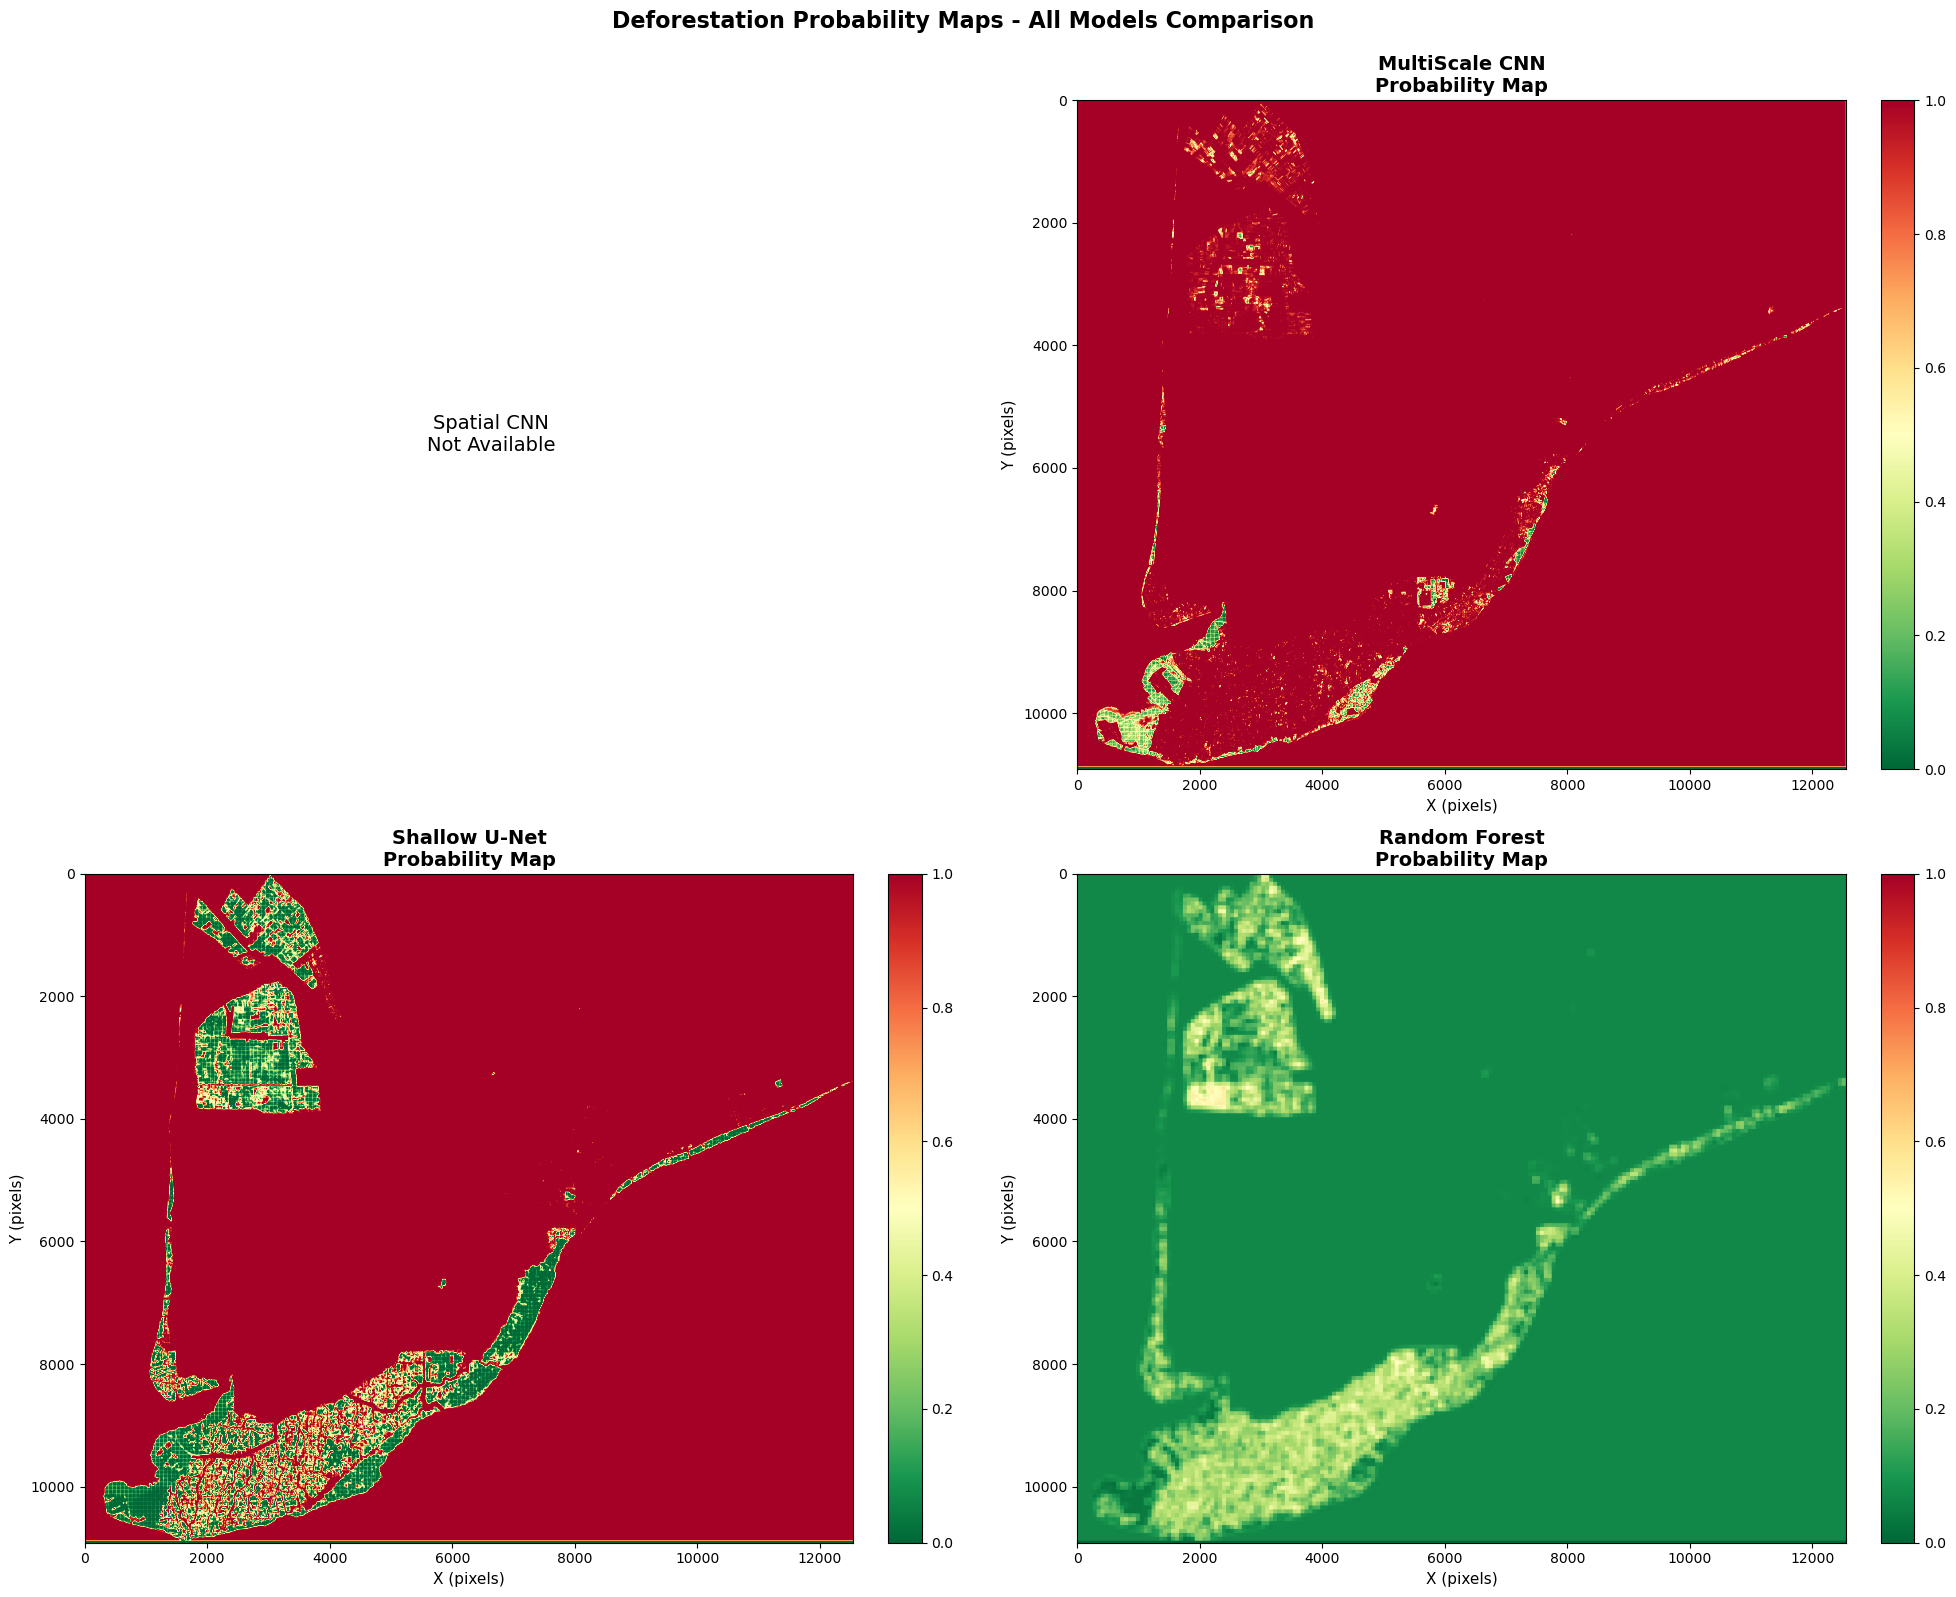

Saved: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\all_models_probability_comparison.png


In [6]:
# Create 2x2 grid for probability maps
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, model in enumerate(models):
    if model['name'] in prob_maps:
        im = axes[i].imshow(prob_maps[model['name']], cmap='RdYlGn_r', vmin=0, vmax=1)
        axes[i].set_title(f"{model['name']}\nProbability Map", 
                         fontsize=14, fontweight='bold')
        axes[i].set_xlabel('X (pixels)', fontsize=11)
        axes[i].set_ylabel('Y (pixels)', fontsize=11)
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"{model['name']}\nNot Available",
                    ha='center', va='center', fontsize=14, 
                    transform=axes[i].transAxes)

plt.suptitle('Deforestation Probability Maps - All Models Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
figures_dir = project_root / 'figures'
figures_dir.mkdir(exist_ok=True)
plt.savefig(figures_dir / 'all_models_probability_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {figures_dir / 'all_models_probability_comparison.png'}")

## 6. Side-by-Side Binary Maps Comparison

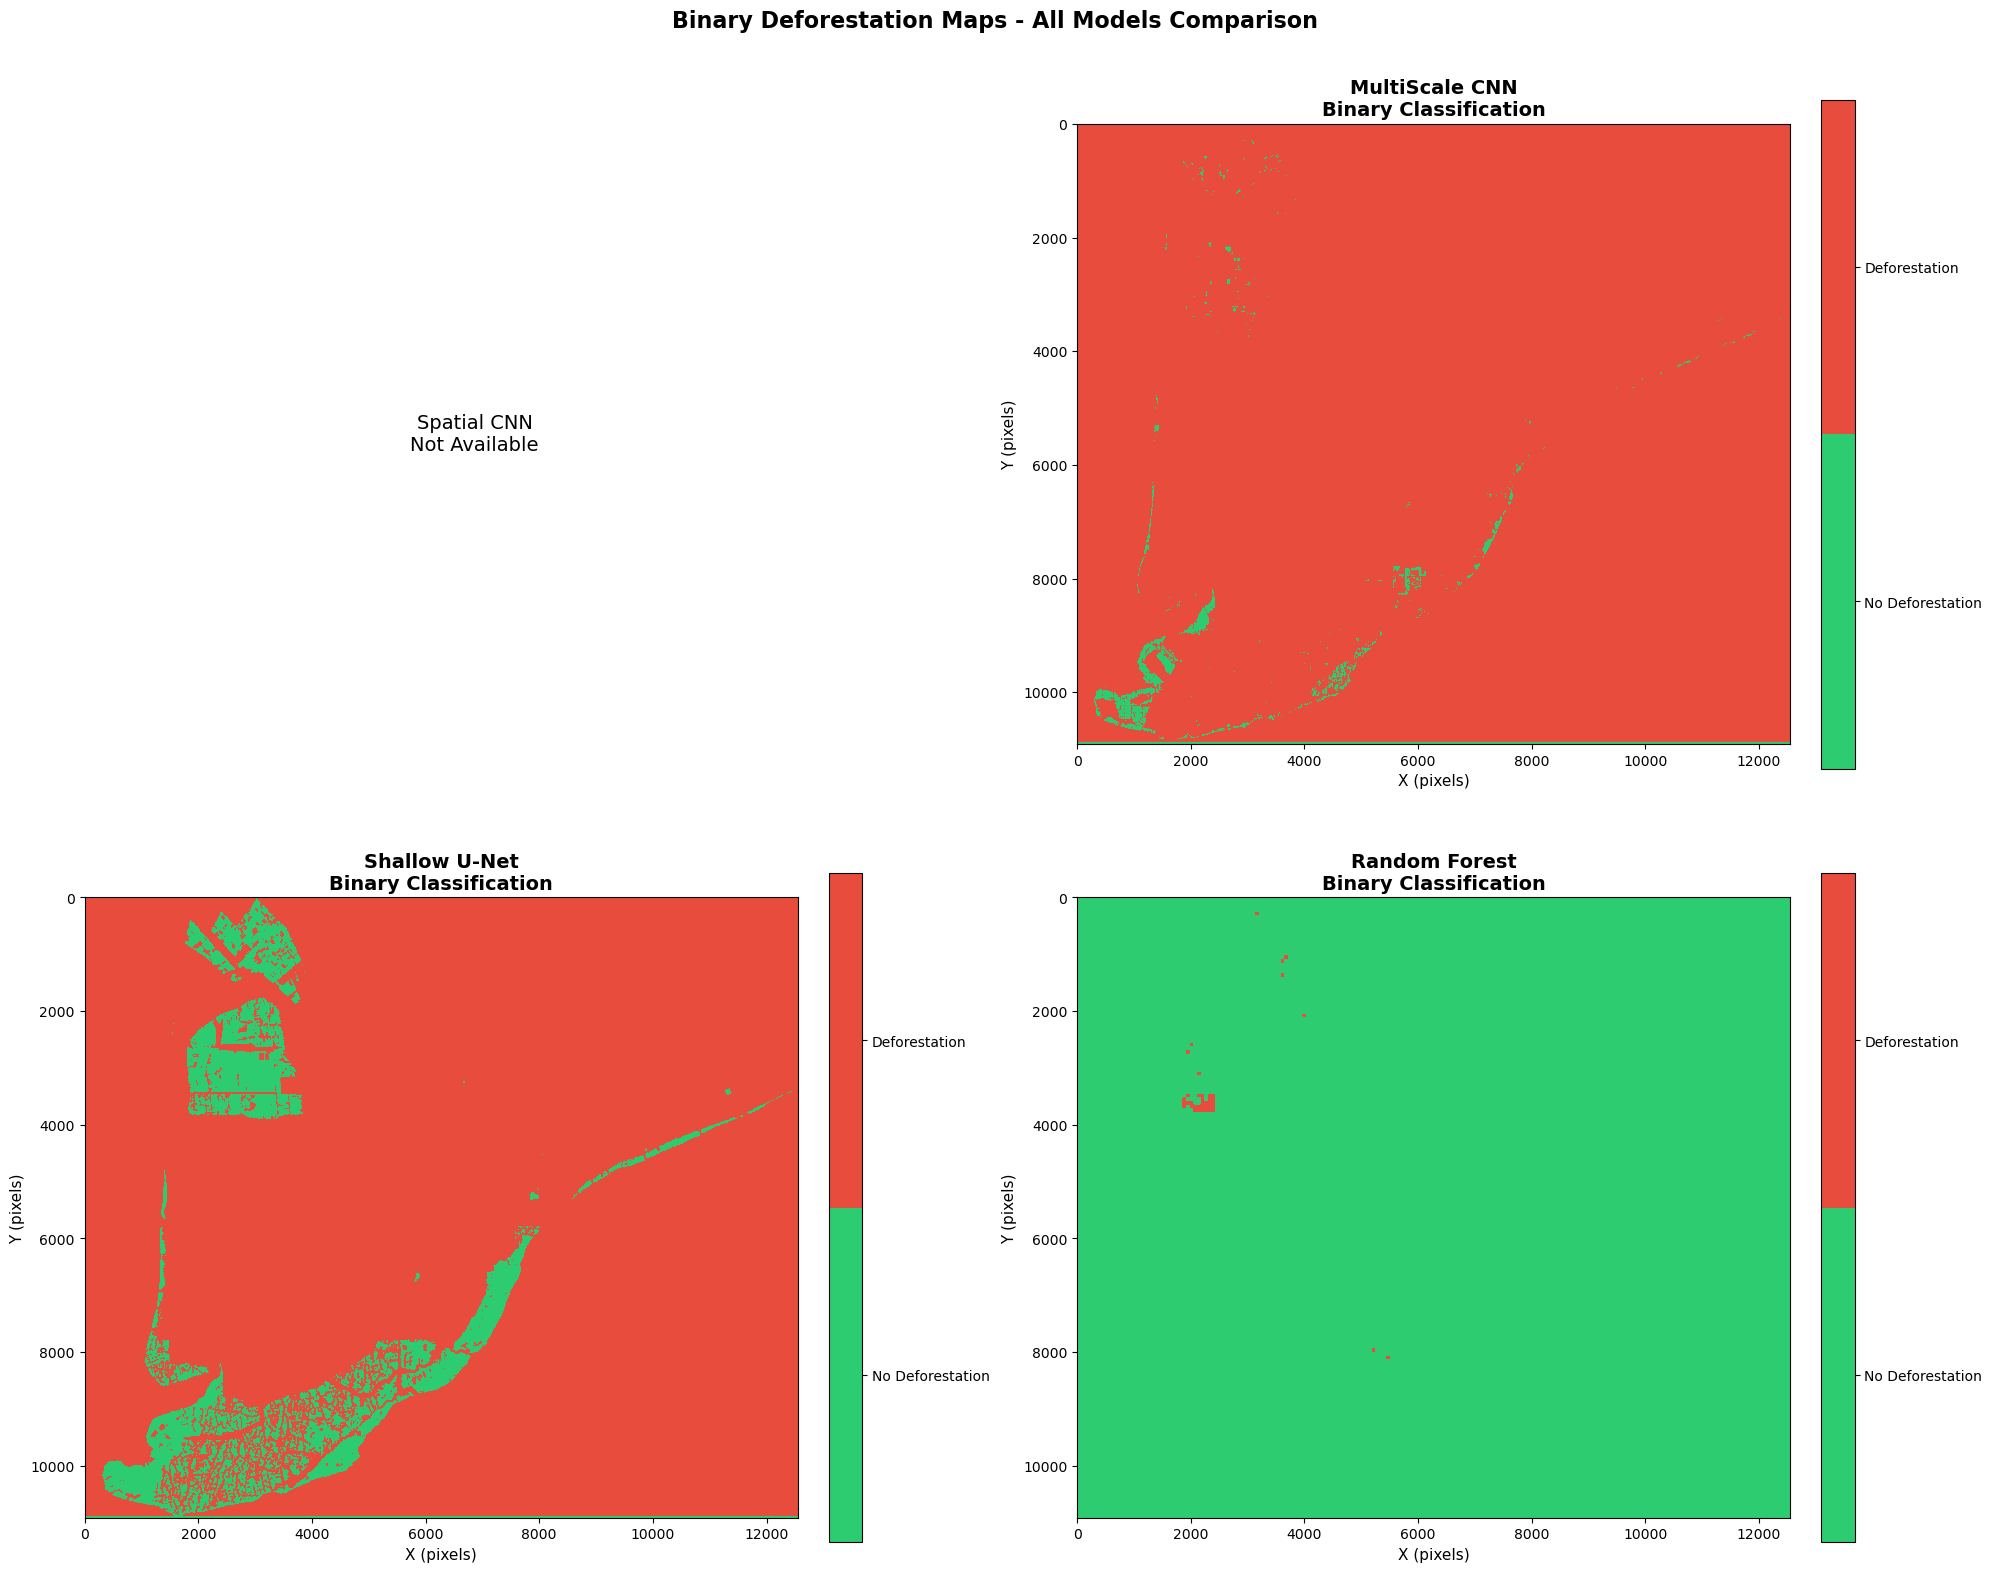

Saved: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\all_models_binary_comparison.png


In [7]:
# Create 2x2 grid for binary maps
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Custom colormap
colors = ['#2ecc71', '#e74c3c']  # Green, Red
cmap = ListedColormap(colors)

for i, model in enumerate(models):
    if model['name'] in binary_maps:
        im = axes[i].imshow(binary_maps[model['name']], cmap=cmap, vmin=0, vmax=1)
        axes[i].set_title(f"{model['name']}\nBinary Classification", 
                         fontsize=14, fontweight='bold')
        axes[i].set_xlabel('X (pixels)', fontsize=11)
        axes[i].set_ylabel('Y (pixels)', fontsize=11)
        cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, 
                           ticks=[0.25, 0.75])
        cbar.ax.set_yticklabels(['No Deforestation', 'Deforestation'], fontsize=10)
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"{model['name']}\nNot Available",
                    ha='center', va='center', fontsize=14, 
                    transform=axes[i].transAxes)

plt.suptitle('Binary Deforestation Maps - All Models Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(figures_dir / 'all_models_binary_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {figures_dir / 'all_models_binary_comparison.png'}")

## 7. Statistics Comparison

In [8]:
# Calculate statistics for each model
pixel_area_m2 = 10.0 * 10.0

stats_data = []
for model in models:
    if model['name'] in binary_maps:
        binary_map = binary_maps[model['name']]
        prob_map = prob_maps[model['name']]
        
        total_pixels = binary_map.size
        defor_pixels = binary_map.sum()
        defor_percentage = (defor_pixels / total_pixels) * 100
        defor_area_km2 = defor_pixels * pixel_area_m2 / 1e6
        
        stats_data.append({
            'Model': model['name'],
            'Deforestation (%)': defor_percentage,
            'Area (km²)': defor_area_km2,
            'Mean Probability': prob_map.mean(),
            'Color': model['color']
        })

# Display statistics table
print("="*80)
print("DEFORESTATION STATISTICS - ALL MODELS")
print("="*80)
print()
for data in stats_data:
    print(f"{data['Model']}:")
    print(f"  Deforestation: {data['Deforestation (%)']:.2f}%")
    print(f"  Area: {data['Area (km²)']:.2f} km²")
    print(f"  Mean Probability: {data['Mean Probability']:.4f}")
    print()

DEFORESTATION STATISTICS - ALL MODELS

MultiScale CNN:
  Deforestation: 98.61%
  Area: 13507.19 km²
  Mean Probability: 0.9854

Shallow U-Net:
  Deforestation: 91.72%
  Area: 12562.85 km²
  Mean Probability: 0.9211

Random Forest:
  Deforestation: 0.12%
  Area: 16.38 km²
  Mean Probability: 0.0931



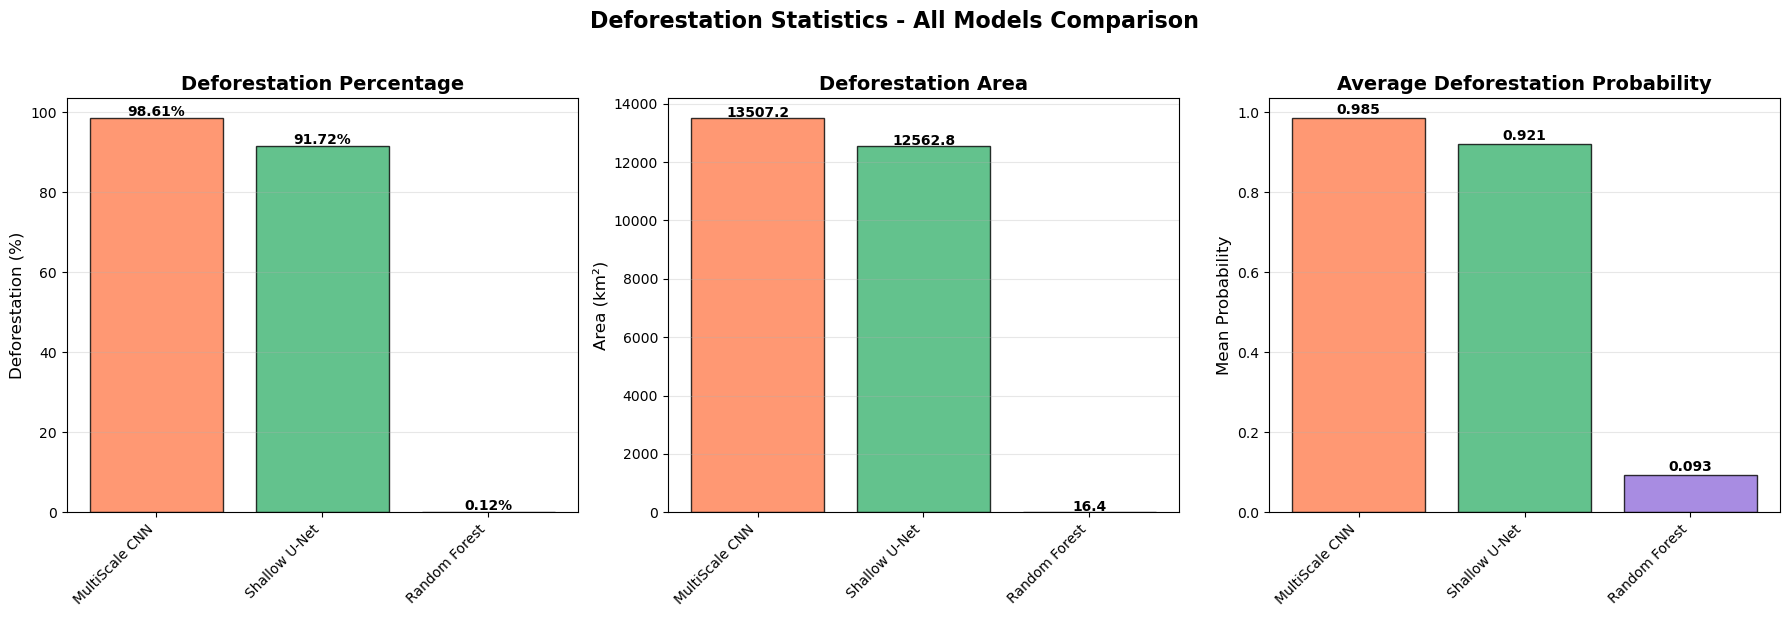

Saved: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\all_models_statistics_comparison.png


In [9]:
# Create bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

model_names = [s['Model'] for s in stats_data]
colors_list = [s['Color'] for s in stats_data]

# 1. Deforestation percentage
defor_pcts = [s['Deforestation (%)'] for s in stats_data]
axes[0].bar(range(len(model_names)), defor_pcts, color=colors_list, 
           edgecolor='black', alpha=0.8)
axes[0].set_xticks(range(len(model_names)))
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].set_ylabel('Deforestation (%)', fontsize=12)
axes[0].set_title('Deforestation Percentage', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(defor_pcts):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', 
                fontsize=10, fontweight='bold')

# 2. Deforestation area
defor_areas = [s['Area (km²)'] for s in stats_data]
axes[1].bar(range(len(model_names)), defor_areas, color=colors_list, 
           edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(model_names)))
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].set_ylabel('Area (km²)', fontsize=12)
axes[1].set_title('Deforestation Area', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(defor_areas):
    axes[1].text(i, v + 20, f'{v:.1f}', ha='center', 
                fontsize=10, fontweight='bold')

# 3. Mean probability
mean_probs = [s['Mean Probability'] for s in stats_data]
axes[2].bar(range(len(model_names)), mean_probs, color=colors_list, 
           edgecolor='black', alpha=0.8)
axes[2].set_xticks(range(len(model_names)))
axes[2].set_xticklabels(model_names, rotation=45, ha='right')
axes[2].set_ylabel('Mean Probability', fontsize=12)
axes[2].set_title('Average Deforestation Probability', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(mean_probs):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', 
                fontsize=10, fontweight='bold')

plt.suptitle('Deforestation Statistics - All Models Comparison',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'all_models_statistics_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {figures_dir / 'all_models_statistics_comparison.png'}")

## 8. CNN Models Agreement Analysis

This section analyzes where the 3 CNN models agree on deforestation detection.

C:\Users\CuongHM\AppData\Local\Temp\ipykernel_16668\2730547470.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_agreement = plt.cm.get_cmap('RdYlGn_r', len(cnn_binary_maps) + 1)


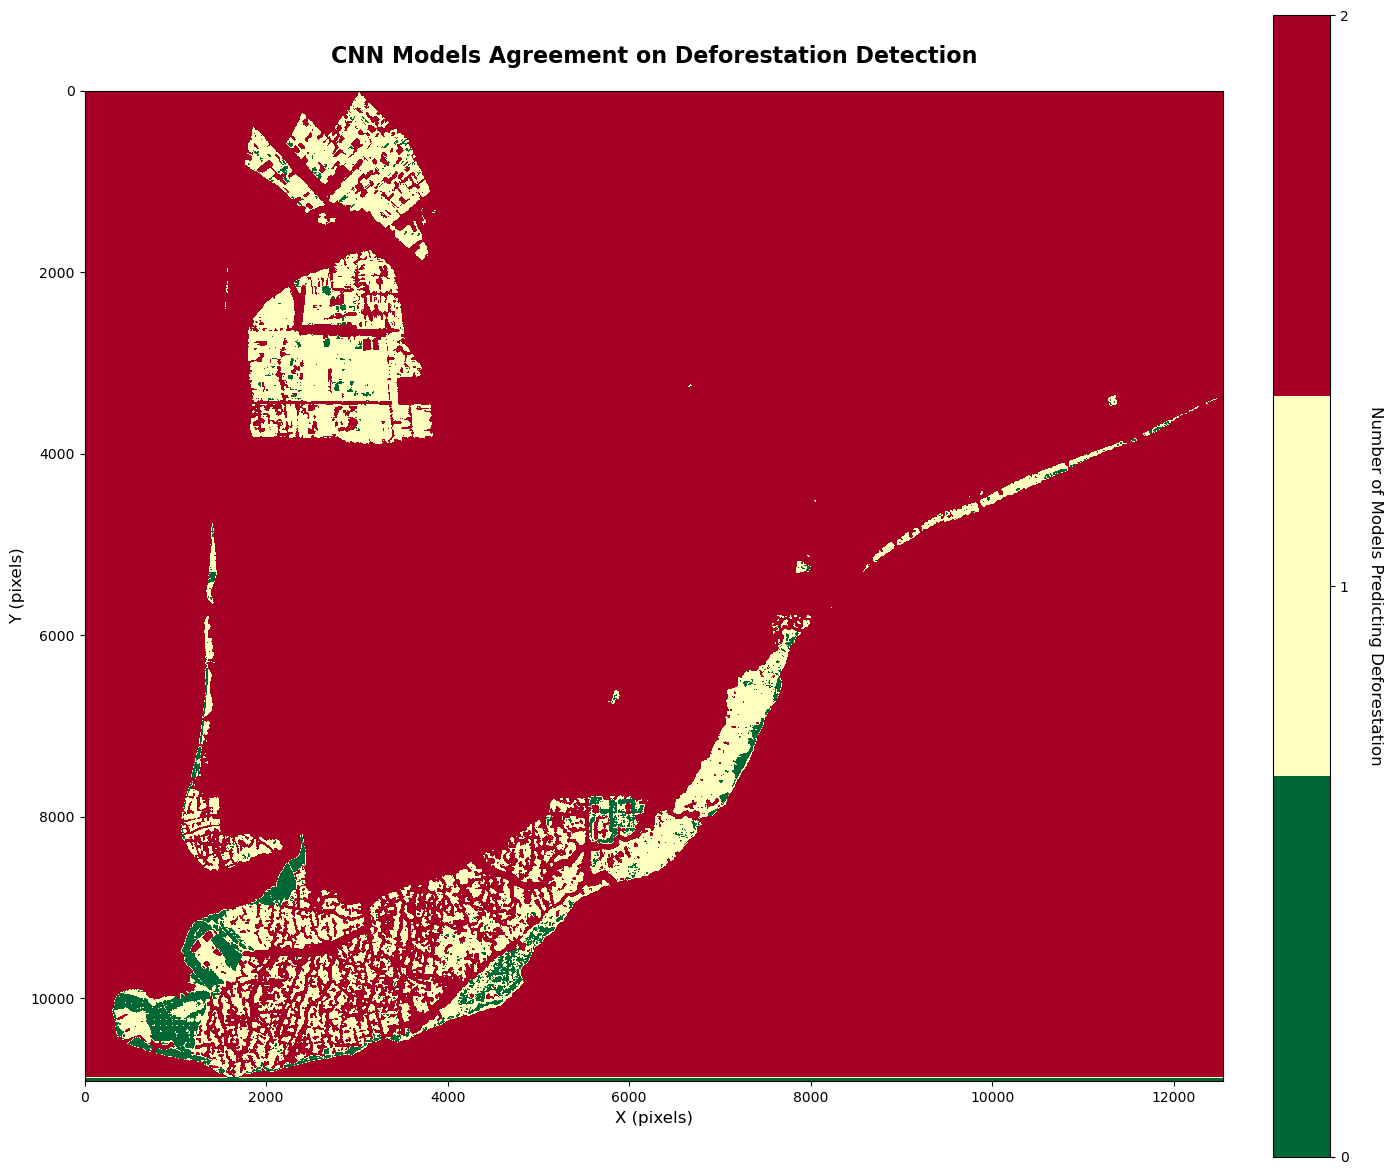

Saved: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\cnn_models_agreement.png

CNN MODELS AGREEMENT:
  0 models agree: 1,839,773 pixels (1.34%)
  1 models agree: 9,571,230 pixels (6.99%)
  2 models agree: 125,564,596 pixels (91.67%)


In [10]:
# Get CNN models only
cnn_models = ['Spatial CNN', 'MultiScale CNN', 'Shallow U-Net']
cnn_binary_maps = [binary_maps[name] for name in cnn_models if name in binary_maps]

if len(cnn_binary_maps) >= 2:
    # Stack binary maps
    stacked = np.stack(cnn_binary_maps, axis=0)
    agreement = stacked.sum(axis=0)  # 0 to N models agree
    
    # Create agreement visualization
    fig, ax = plt.subplots(figsize=(14, 12))
    cmap_agreement = plt.cm.get_cmap('RdYlGn_r', len(cnn_binary_maps) + 1)
    im = ax.imshow(agreement, cmap=cmap_agreement, vmin=0, vmax=len(cnn_binary_maps))
    ax.set_title('CNN Models Agreement on Deforestation Detection',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('X (pixels)', fontsize=12)
    ax.set_ylabel('Y (pixels)', fontsize=12)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04,
                       ticks=range(len(cnn_binary_maps) + 1))
    cbar.set_label('Number of Models Predicting Deforestation',
                  fontsize=12, rotation=270, labelpad=25)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'cnn_models_agreement.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {figures_dir / 'cnn_models_agreement.png'}")
    
    # Agreement statistics
    agreement_counts = np.bincount(agreement.flatten(), 
                                   minlength=len(cnn_binary_maps) + 1)
    agreement_pcts = agreement_counts / agreement.size * 100
    
    print("\n" + "="*80)
    print("CNN MODELS AGREEMENT:")
    print("="*80)
    for i, (count, pct) in enumerate(zip(agreement_counts, agreement_pcts)):
        print(f"  {i} models agree: {count:,} pixels ({pct:.2f}%)")
    print("="*80)
else:
    print("Not enough CNN models for agreement analysis")

## 9. Model Differences Heatmap

Visualize the differences between model predictions.

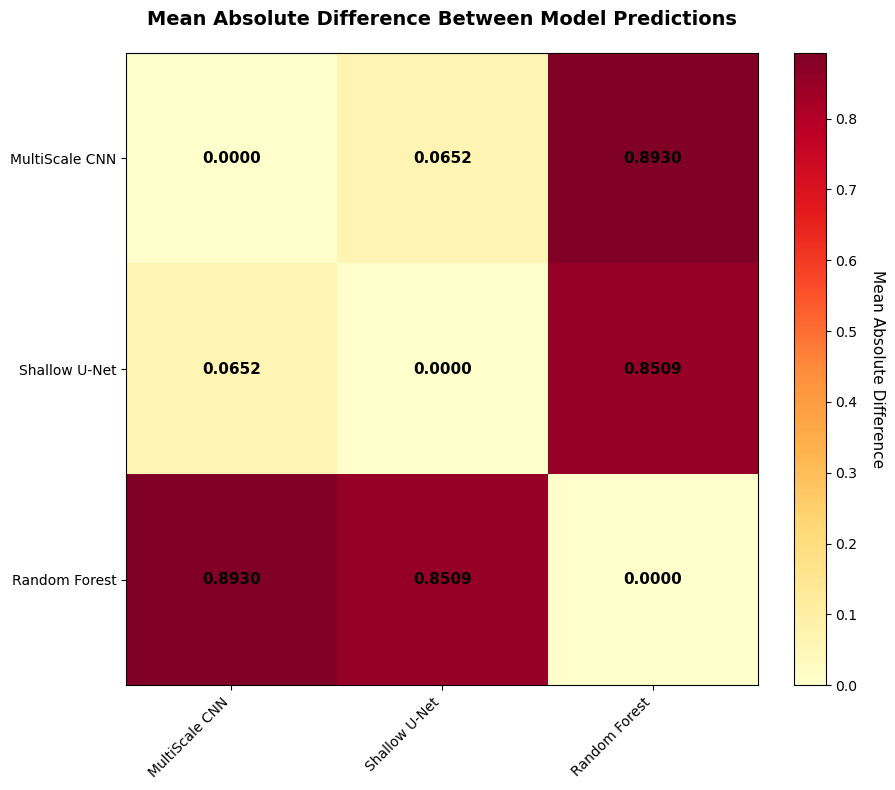

Saved: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\figures\models_difference_heatmap.png


In [11]:
# Calculate pairwise differences between models
if len(prob_maps) >= 2:
    model_names_list = list(prob_maps.keys())
    n_models = len(model_names_list)
    
    # Calculate mean absolute differences
    diff_matrix = np.zeros((n_models, n_models))
    
    for i, name1 in enumerate(model_names_list):
        for j, name2 in enumerate(model_names_list):
            if i != j:
                diff = np.abs(prob_maps[name1] - prob_maps[name2]).mean()
                diff_matrix[i, j] = diff
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(diff_matrix, cmap='YlOrRd', vmin=0)
    
    # Set ticks
    ax.set_xticks(range(n_models))
    ax.set_yticks(range(n_models))
    ax.set_xticklabels(model_names_list, rotation=45, ha='right')
    ax.set_yticklabels(model_names_list)
    
    # Add text annotations
    for i in range(n_models):
        for j in range(n_models):
            text = ax.text(j, i, f'{diff_matrix[i, j]:.4f}',
                          ha="center", va="center", color="black", 
                          fontsize=11, fontweight='bold')
    
    ax.set_title('Mean Absolute Difference Between Model Predictions',
                fontsize=14, fontweight='bold', pad=20)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Mean Absolute Difference', fontsize=11, rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'models_difference_heatmap.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {figures_dir / 'models_difference_heatmap.png'}")

## 10. Save Comparison Summary

In [12]:
# Save summary report
summary_path = outputs_dir / 'all_models_comparison_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("ALL MODELS COMPARISON SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write("DEFORESTATION STATISTICS:\n")
    f.write("-"*80 + "\n")
    for data in stats_data:
        f.write(f"\n{data['Model']}:\n")
        f.write(f"  Deforestation: {data['Deforestation (%)']:.2f}%\n")
        f.write(f"  Area: {data['Area (km²)']:.2f} km²\n")
        f.write(f"  Mean Probability: {data['Mean Probability']:.4f}\n")
    
    if len(cnn_binary_maps) >= 2:
        f.write("\n\nCNN MODELS AGREEMENT:\n")
        f.write("-"*80 + "\n")
        for i, (count, pct) in enumerate(zip(agreement_counts, agreement_pcts)):
            f.write(f"  {i} models agree: {count:,} pixels ({pct:.2f}%)\n")
    
    f.write("\n\nGENERATED FIGURES:\n")
    f.write("-"*80 + "\n")
    f.write("  - all_models_probability_comparison.png\n")
    f.write("  - all_models_binary_comparison.png\n")
    f.write("  - all_models_statistics_comparison.png\n")
    f.write("  - cnn_models_agreement.png\n")
    f.write("  - models_difference_heatmap.png\n")

print(f"Summary saved to: {summary_path}")

# Display summary
with open(summary_path, 'r', encoding='utf-8') as f:
    print("\n" + f.read())

Summary saved to: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\outputs\all_models_comparison_summary.txt

ALL MODELS COMPARISON SUMMARY

DEFORESTATION STATISTICS:
--------------------------------------------------------------------------------

MultiScale CNN:
  Deforestation: 98.61%
  Area: 13507.19 km²
  Mean Probability: 0.9854

Shallow U-Net:
  Deforestation: 91.72%
  Area: 12562.85 km²
  Mean Probability: 0.9211

Random Forest:
  Deforestation: 0.12%
  Area: 16.38 km²
  Mean Probability: 0.0931


CNN MODELS AGREEMENT:
--------------------------------------------------------------------------------
  0 models agree: 1,839,773 pixels (1.34%)
  1 models agree: 9,571,230 pixels (6.99%)
  2 models agree: 125,564,596 pixels (91.67%)


GENERATED FIGURES:
--------------------------------------------------------------------------------
  - all_models_probability_comparison.png
  - all_models_binary_comparison.png
  - all_models_statistics_comparison.png
  - cnn_models_agreement.png
  - models

## 11. Summary

This notebook has generated comprehensive comparisons between all 4 deforestation detection models:

**Visualizations created:**
1. Side-by-side probability maps (2×2 grid)
2. Side-by-side binary classification maps (2×2 grid)
3. Statistics comparison (bar charts)
4. CNN models agreement analysis
5. Model differences heatmap

**Key insights:**
- Compare deforestation estimates across different model architectures
- Identify areas of high agreement (high confidence predictions)
- Identify areas of disagreement (uncertain predictions)
- Evaluate trade-offs between CNN models and traditional ML (Random Forest)

All figures have been saved to `figures/` directory for inclusion in your thesis.